In [1]:
import os
import numpy
import json

In [2]:
pths = {
    "depth": "./models/NF.15/Visnav_VR_Expt/visnav_tigre/Neuroformer/pretrain_depth_luminance/(state_history=6,_state=6,_stimulus=0,_behavior=0,_self_att=6,_modalities=(n_behavior=25))/420/inference/behavior_preds_depth.pkl",
    "luminance": "./models/NF.15/Visnav_VR_Expt/visnav_tigre/Neuroformer/pretrain_depth_luminance/(state_history=6,_state=6,_stimulus=0,_behavior=0,_self_att=6,_modalities=(n_behavior=25))/420/inference/behavior_preds_luminance.pkl"
}

def load_data(data_dict):
    for key, pth in pths.items():
        if pth.endswith(".json"):
            with open(pth, "r") as f:
                data_dict[key] = json.load(f)
        elif pth.endswith(".pkl"):
            data_dict[key] = numpy.load(pth, allow_pickle=True)
    return data_dict

data = load_data(pths)

In [3]:
predict_modes = ['depth', 'luminance']
model_name = 'NF.1.6'
dataset = 'Visnav_Tigre'
behavior_preds = data
behavior_preds.keys()

dict_keys(['depth', 'luminance'])

behavior_preds_mode: dict_keys(['block_type_modality', 'modality_preds', 'interval', 'trial', 'true', 'cum_interval'])


/share/edc/home/antonis/neuroformer_clean/Neuroformer_2/Neuroformer/neuroformer/visualize.py:1065: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(combined_limits, combined_limits, 'k--', color='black')


behavior_preds_mode: dict_keys(['block_type_modality', 'modality_preds', 'interval', 'trial', 'true', 'cum_interval'])


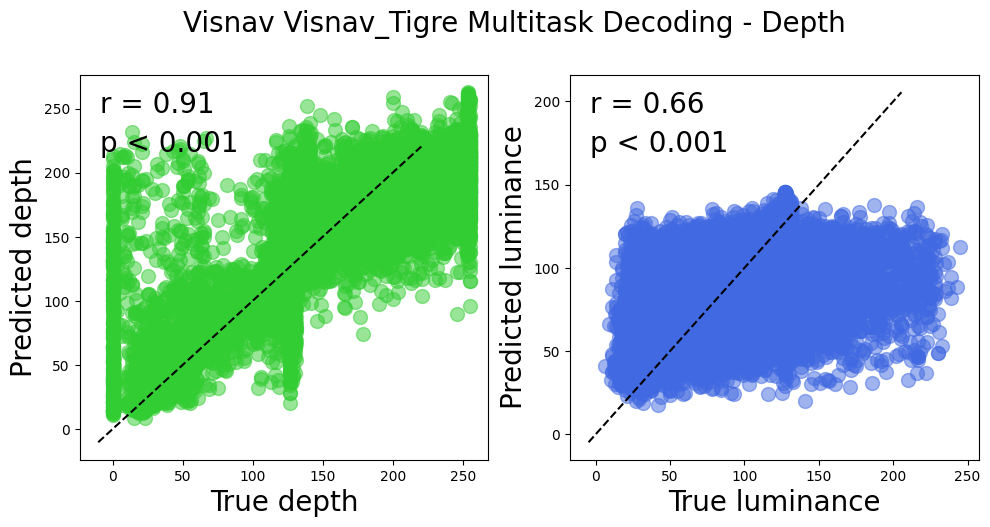

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from neuroformer.visualize import plot_regression

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(5.8 * len(predict_modes), 5), nrows=1, ncols=len(predict_modes))
plt.suptitle(f'Visnav {dataset} Multitask Decoding - Depth', fontsize=20, y=1.01)
colors = ['limegreen', 'royalblue', 'darkblue']  # Define your colors here

# Function to expand intervals to match the number of predictions
def expand_intervals(cum_intervals, predictions_length):
    expanded_intervals = np.zeros(predictions_length)
    interval_len = predictions_length // len(cum_intervals)
    for i in range(len(cum_intervals)):
        start_idx = i * interval_len
        end_idx = start_idx + interval_len
        expanded_intervals[start_idx:end_idx] = cum_intervals[i]
    return expanded_intervals

# Loop through each prediction mode
for n, mode in enumerate(predict_modes):
    behavior_preds_mode = behavior_preds[mode]

    print(f"behavior_preds_mode: {behavior_preds_mode.keys()}")

    true_values = behavior_preds_mode['true']
    pred_values = behavior_preds_mode['modality_preds']

    # limit to 1/100th of the data for plotting
    n_vals = len(true_values) // 1000
    indexes = np.random.choice(len(true_values), n_vals, replace=False)
    true_values = np.array(true_values)[indexes]
    pred_values = np.array(pred_values)[indexes]

    # Calculate Pearson correlation coefficient
    r, p = pearsonr(true_values, pred_values)

    # Plot the results
    axis = ax[n]
    plot_regression(true_values, pred_values, mode, model_name, r, p, ax=axis, color=colors[n])

plt.show()


In [5]:
preds_ = behavior_preds['luminance']

stim_shape = (100, 290)

len(preds_['modality_preds']) / (stim_shape[0] * stim_shape[1])


preds_flat = np.array(preds_['modality_preds']).reshape(-1, stim_shape[0] * stim_shape[1])
true_depth_flat = np.array(preds_['true']).reshape(-1, stim_shape[0] * stim_shape[1])

# preds_depth_flat = np.array(pred_values).reshape(-1, stim_shape[0] * stim_shape[1])
# true_depth_flat = np.array(true_values).reshape(-1, stim_shape[0] * stim_shape[1])

r_flat = np.zeros((preds_flat.shape[-1]))

for i in range(preds_flat.shape[-1]):
    r_flat[i], _ = pearsonr(preds_flat[:, i], true_depth_flat[:, i])

r_flat = np.nan_to_num(r_flat)
# preds_depth_xy = np.array(preds_depth['modality_preds']).reshape(-1, stim_shape[0], stim_shape[1])
# true_depth_xy = np.array(preds_depth['true']).reshape(-1, stim_shape[0], stim_shape[1])

/tmp/ipykernel_609285/1327239398.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_flat[i], _ = pearsonr(preds_flat[:, i], true_depth_flat[:, i])


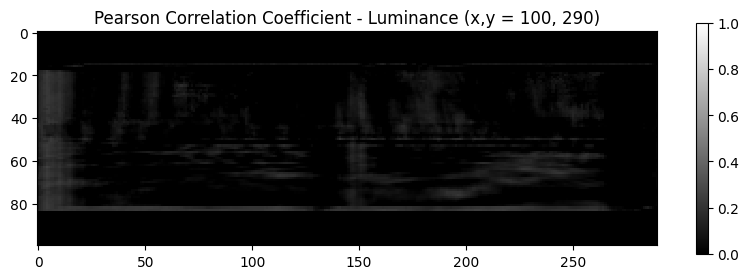

In [6]:
r_flat = np.array(r_flat)
r_flat.shape

# reshape
r_xy = r_flat.reshape(stim_shape)

# plot as heatmap
plt.figure(figsize=(10, 5))
plt.title('Pearson Correlation Coefficient - Luminance (x,y = 100, 290)')
plt.imshow(r_xy, cmap='gray', interpolation='nearest')
plt.colorbar(shrink=0.6)
plt.clim(0, 1)

In [7]:
print(f"mean: {np.mean(r_flat)}")

mean: -0.0022689738081517704
